# 1 Construct LSH Hash Tables


### a)Load bitvector users.csv. Construct a feature vector for each user in the dataset. Please report the number of users (|U |) and the number of features (n) for the loaded data


In [52]:

import pandas as pd
import numpy as np
import random
from collections import defaultdict
from itertools import combinations


# Load the dataset
data = pd.read_csv('bitvector_users.csv', sep='\t', header=None)

# The first column is the User_ID, and the rest are the visited businesses
data['User_ID'] = data.iloc[:, 0]
data['Visited_Businesses'] = data.iloc[:, 1:].values.tolist()  # Convert remaining columns to a list of bitvectors

# Now you have two columns: User_ID and Visited_Businesses
print(f"Number of users: {data.shape[0]}")
print(f"Number of features (businesses): {data.shape[1] - 1}")

# Verify the structure
# print(data.head())


Number of users: 2574
Number of features (businesses): 7857
   0  1  2  3  4  5  6  7  8  9  ...  7848  7849  7850  7851  7852  7853  \
0  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  1  0  1  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  2  0  0  1  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3  3  0  0  1  1  0  0  0  0  0  ...     0     0     0     0     0     0   
4  4  0  0  0  0  1  0  0  0  0  ...     0     0     0     0     0     0   

   7854  7855  User_ID                                 Visited_Businesses  
0     0     0        0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     0     0        1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     0     0        2  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
3     0     0        3  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
4     0     0        4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[5 rows x 7858 columns]


### b)onstruct a family of MinHash functions in the LSH family. You can choose a prime number, denoted as p, and coefficients 0 < a < p, 0 ≤ b < p. Let the tunable hash size k, and report the family of MinHash functions you have generated with k ∈ {1, 2, 3, 4}, respectively. 

In [54]:
import random

# Prime number and coefficients
p = 753  # Example prime number, you can change it if necessary
k_values = [1, 2, 3, 4]  # Values of k to be tested

# Generate MinHash functions
def generate_minhash_functions(k, p, num_features):
    minhash_functions = []
    for _ in range(k):
        a = random.randint(1, p - 1)  # a is between 1 and p-1
        b = random.randint(0, p - 1)  # b is between 0 and p-1
        minhash_functions.append((a, b))
    return minhash_functions

# Generate MinHash functions for k = 1, 2, 3, 4 and report them
for k in k_values:
    functions = generate_minhash_functions(k, p, num_features)
    print(f"MinHash functions for k = {k}: {functions}")


MinHash functions for k = 1: [(363, 351)]
MinHash functions for k = 2: [(3, 356), (213, 511)]
MinHash functions for k = 3: [(463, 382), (265, 370), (225, 422)]
MinHash functions for k = 4: [(68, 320), (45, 376), (351, 667), (365, 428)]


### c) Construct one (L = 1) LSH hash table2 using MinHash functions with bucket size (m = 3000) with k = 2. Report all users collided with the user with ID = 2186 in the constructed hash table and their corresponding Jaccard similarity. 

In [56]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict


# Parameters
k = 2  # Number of hash functions
bucket_size = 3000  # Size of buckets for hashing
user_id_target = 2186  # Target user ID

# Step 2: MinHash function
def generate_minhash_functions(k, p, num_features):
    minhash_functions = []
    for _ in range(k):
        a = random.randint(1, p-1)
        b = random.randint(0, p-1)
        minhash_functions.append((a, b))
    return minhash_functions

# Apply MinHash to a user's bit vector
def minhash(bit_vector, hash_function, p, num_features):
    a, b = hash_function
    # Simple hashing based on dot product and modulo prime p
    return (a * np.dot(bit_vector, np.arange(num_features)) + b) % p

# Step 3: Construct one LSH hash table
def construct_lsh_table(data, k, p, bucket_size):
    num_features = len(data['Visited_Businesses'][0])  # Number of businesses/features
    hash_functions = generate_minhash_functions(k, p, num_features)
    
    lsh_table = defaultdict(list)

    for index, row in data.iterrows():
        user_id = row['User_ID']
        bit_vector = row['Visited_Businesses']
        # Generate the minhash signature for the user
        minhash_signature = tuple([minhash(bit_vector, h, p, num_features) for h in hash_functions])
        bucket = hash(minhash_signature) % bucket_size
        lsh_table[bucket].append(user_id)
    
    return lsh_table, hash_functions

# Step 4: Compute Jaccard similarity
def jaccard_similarity(vec1, vec2):
    intersection = np.sum(np.minimum(vec1, vec2))
    union = np.sum(np.maximum(vec1, vec2))
    return intersection / union

# Construct the LSH table with k=2
lsh_table, hash_functions = construct_lsh_table(data, k=2, p=p, bucket_size=bucket_size)

# Find the bucket for the target user (ID=2186)
target_vector = data[data['User_ID'] == user_id_target]['Visited_Businesses'].values[0]
target_signature = tuple([minhash(target_vector, h, p, len(target_vector)) for h in hash_functions])
target_bucket = hash(target_signature) % bucket_size

# Step 5: Find all users who collide with the target user
collided_users = lsh_table[target_bucket]

# Step 6: Compute Jaccard similarity for each collided user
similarities = []
for user_id in collided_users:
    if user_id == user_id_target:
        continue  # Skip the target user itself
    user_vector = data[data['User_ID'] == user_id]['Visited_Businesses'].values[0]
    similarity = jaccard_similarity(target_vector, user_vector)
    similarities.append((user_id, similarity))

# Sort collided users by Jaccard similarity in descending order
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

# Step 7: Print the results
print(f"Users collided with user {user_id_target}:")
for user, sim in similarities:
    print(f"User {user} with Jaccard similarity: {sim:.4f}")


Users collided with user 2186:
User 2050 with Jaccard similarity: 0.8779
User 2527 with Jaccard similarity: 0.7939
User 1105 with Jaccard similarity: 0.4715
User 676 with Jaccard similarity: 0.2796
User 179 with Jaccard similarity: 0.0769


### d)Construct L = 10 LSH hash tables using MinHash functions with bucket size (m = 3000) and k = 2. Report all users collided with the user with ID = 2186 in at least one hash table and their corresponding Jaccard similarit

In [57]:
# Parameter
L = 10  # Number of LSH tables

# Construct multiple LSH tables
def construct_multiple_lsh_tables(data, L, k, p, bucket_size):
    num_features = len(data['Visited_Businesses'][0])
    lsh_tables = []
    for _ in range(L):
        hash_functions = generate_minhash_functions(k, p, num_features)
        lsh_table = defaultdict(list)
        for index, row in data.iterrows():
            user_id = row['User_ID']
            bit_vector = row['Visited_Businesses']
            minhash_signature = tuple([minhash(bit_vector, h, p, num_features) for h in hash_functions])
            bucket = hash(minhash_signature) % bucket_size
            lsh_table[bucket].append(user_id)
        lsh_tables.append((lsh_table, hash_functions))
    return lsh_tables

lsh_tables = construct_multiple_lsh_tables(data, L, k=2, p=p, bucket_size=bucket_size)


# Find the users that collide with the target user (ID=2186) in at least one table
target_vector = data[data['User_ID'] == user_id_target]['Visited_Businesses'].values[0]
collided_users_set = set()

for lsh_table, hash_functions in lsh_tables:
    target_signature = tuple([minhash(target_vector, h, p, len(target_vector)) for h in hash_functions])
    target_bucket = hash(target_signature) % bucket_size
    collided_users_set.update(lsh_table[target_bucket])

#Compute Jaccard similarity for each collided user
similarities = []
for user_id in collided_users_set:
    if user_id == user_id_target:
        continue  # Skip the target user itself
    user_vector = data[data['User_ID'] == user_id]['Visited_Businesses'].values[0]
    similarity = jaccard_similarity(target_vector, user_vector)
    similarities.append((user_id, similarity))

# Sort by similarity
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
#Print the results
print(f"Users collided with user {user_id_target} in at least one LSH table:")
for user, sim in similarities:
    print(f"User {user} with Jaccard similarity: {sim:.4f}")


Users collided with user 2186 in at least one LSH table:
User 2103 with Jaccard similarity: 0.8957
User 2385 with Jaccard similarity: 0.8262
User 1812 with Jaccard similarity: 0.7728
User 1440 with Jaccard similarity: 0.6146
User 1276 with Jaccard similarity: 0.5488
User 1275 with Jaccard similarity: 0.5309
User 1232 with Jaccard similarity: 0.5101
User 437 with Jaccard similarity: 0.1881


# Nearest Neighbor Search

### a)uery the LSH tables constructed in Question 1(d) and return the top-5 users with the highest Jaccard similarities as the answer. Consider a query set of user IDs Q = {295, 1053, 1080, 2186}. To compute the search results for each query user q ∈ Q by following the three steps

1): find the set of users Uq that collide with q ∈ Q in at least one hash table.

In [58]:
# Step 1: Define the query set Q
query_set = [295, 1053, 1080, 2186]

# Function to find collided users in LSH tables
def find_collided_users(query_vector, lsh_tables, p, num_features, bucket_size):
    collided_users = set()  # Use a set to avoid duplicate users
    for lsh_table, hash_functions in lsh_tables:
        # Compute MinHash signature for the query user
        query_signature = tuple([minhash(query_vector, h, p, num_features) for h in hash_functions])
        bucket = hash(query_signature) % bucket_size  # Find the bucket the query user hashes to
        collided_users.update(lsh_table[bucket])  # Add users in the same bucket
    return collided_users

# Function to get collided users for each query user
def get_collided_users_for_queries(query_set, lsh_tables, data):
    collided_results = {}
    for query_id in query_set:
        # Get the vector for the query user
        query_vector = data[data['User_ID'] == query_id]['Visited_Businesses'].values[0]
        
        # Find all users that collide with the query user in at least one LSH table
        collided_users = find_collided_users(query_vector, lsh_tables, p, len(query_vector), bucket_size)
        
        # Store the results for this query user
        collided_results[query_id] = collided_users
    
    return collided_results

# Step 2: Get collided users for the query set Q
collided_users_results = get_collided_users_for_queries(query_set, lsh_tables, data)

# Step 3: Print the results
for query, collided_users in collided_users_results.items():
    print(f"Query User {query} collided with the following users in at least one LSH table: {collided_users}")

Query User 295 collided with the following users in at least one LSH table: {295, 1034, 2096, 2290, 2263, 2299}
Query User 1053 collided with the following users in at least one LSH table: {2017, 390, 2312, 1261, 750, 2193, 379, 600, 1243, 1053, 1791}
Query User 1080 collided with the following users in at least one LSH table: {248, 34, 1827, 614, 1094, 1832, 107, 1421, 975, 1168, 1810, 659, 2450, 1141, 1080, 1790}
Query User 2186 collided with the following users in at least one LSH table: {1440, 2186, 1232, 2385, 1812, 437, 2103, 1275, 1276}


2) compute the Jaccard similarity between each query q ∈ Q and each user ui ∈ Uq

In [59]:
# Function to compute Jaccard similarities between query and collided users
def compute_jaccard_similarities(collided_users_results, data):
    similarities_results = {}
    
    for query_id, collided_users in collided_users_results.items():
        query_vector = data[data['User_ID'] == query_id]['Visited_Businesses'].values[0]
        
        similarities = []
        for user_id in collided_users:
            if user_id == query_id:  # Skip the query user itself
                continue
            
            user_vector = data[data['User_ID'] == user_id]['Visited_Businesses'].values[0]
            similarity = jaccard_similarity(query_vector, user_vector)
            similarities.append((user_id, similarity))
        
        # Store similarities for this query
        similarities_results[query_id] = similarities
    
    return similarities_results

# Step 1: Compute Jaccard similarities for the query users and their collided users
similarities_results = compute_jaccard_similarities(collided_users_results, data)

# Step 2: Print the results
for query, similarities in similarities_results.items():
    print(f"Jaccard similarities for Query User {query}:")
    for user, similarity in similarities:
        print(f"User {user} with Jaccard similarity: {similarity:.4f}")

Jaccard similarities for Query User 295:
User 1034 with Jaccard similarity: 0.2532
User 2096 with Jaccard similarity: 0.1336
User 2290 with Jaccard similarity: 0.1247
User 2263 with Jaccard similarity: 0.1224
User 2299 with Jaccard similarity: 0.1197
Jaccard similarities for Query User 1053:
User 2017 with Jaccard similarity: 0.4830
User 390 with Jaccard similarity: 0.3159
User 2312 with Jaccard similarity: 0.4093
User 1261 with Jaccard similarity: 0.7263
User 750 with Jaccard similarity: 0.6182
User 2193 with Jaccard similarity: 0.4268
User 379 with Jaccard similarity: 0.3101
User 600 with Jaccard similarity: 0.4894
User 1243 with Jaccard similarity: 0.7502
User 1791 with Jaccard similarity: 0.5259
Jaccard similarities for Query User 1080:
User 248 with Jaccard similarity: 0.2058
User 34 with Jaccard similarity: 0.0308
User 1827 with Jaccard similarity: 0.5471
User 614 with Jaccard similarity: 0.5058
User 1094 with Jaccard similarity: 0.8361
User 1832 with Jaccard similarity: 0.5541
U

3) report the top-5 users with the highest Jaccard similarity for EACH query q ∈ Q. Arrange the
list in descending order based on the Jaccard similarity. That is, the user with the highest
Jaccard similarity should be ranked first place. The resulting list of top-5 similar users for each
query should follow the format below:
Query : q, Top-k : [(u1, sim(q, u1)), ..., (u5, sim(q, u5))],
where q is the query user ID, u1, ..., u5 denotes the ID of the top-5 similar users and sim(q, ui)
is the Jaccard similarity between the query q and its top-i similar user ui.

In [60]:
# Function to get the top-5 most similar users based on Jaccard similarity
def get_top_k_similar_users(similarities_results, k=5):
    top_k_results = {}
    
    for query_id, similarities in similarities_results.items():
        # Sort similarities in descending order
        sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
        
        # Get the top-k similar users
        top_k_users = sorted_similarities[:k]
        
        # Store the top-k results for this query user
        top_k_results[query_id] = top_k_users
    
    return top_k_results

# Step 1: Get the top-5 most similar users for each query user
top_5_similar_users = get_top_k_similar_users(similarities_results, k=5)

# Step 2: Print the top-5 similar users for each query user
for query, top_users in top_5_similar_users.items():
    print(f"Query: {query}, Top-5 similar users: {[(user, round(sim, 4)) for user, sim in top_users]}")


Query: 295, Top-5 similar users: [(1034, 0.2532), (2096, 0.1336), (2290, 0.1247), (2263, 0.1224), (2299, 0.1197)]
Query: 1053, Top-5 similar users: [(1243, 0.7502), (1261, 0.7263), (750, 0.6182), (1791, 0.5259), (600, 0.4894)]
Query: 1080, Top-5 similar users: [(1141, 0.8474), (1094, 0.8361), (1168, 0.7696), (1421, 0.6865), (975, 0.6261)]
Query: 2186, Top-5 similar users: [(2103, 0.8957), (2385, 0.8262), (1812, 0.7728), (1440, 0.6146), (1276, 0.5488)]


b) consider the same query set Q, compute the true top-5 similar users from the dataset. That is, for
each query q ∈ Q, compute the Jaccard similarity between the query q and all users U , and report
the list of top-5 users with the highest Jaccard similarity in descending order. The resulting list of
top-5 similar users for each query should follow the same format as in Question 2(a)

In [61]:
# Function to compute true top-5 similar users based on Jaccard similarity
def compute_true_top_k_similar_users(query_set, data, k=5):
    true_top_k_results = {}
    
    for query_id in query_set:
        # Get the vector for the query user
        query_vector = data[data['User_ID'] == query_id]['Visited_Businesses'].values[0]
        
        similarities = []
        # Compute Jaccard similarity with every user in the dataset
        for _, row in data.iterrows():
            user_id = row['User_ID']
            if user_id == query_id:  # Skip the query user itself
                continue
            
            user_vector = row['Visited_Businesses']
            similarity = jaccard_similarity(query_vector, user_vector)
            similarities.append((user_id, similarity))
        
        # Sort the users by similarity in descending order and get the top-k
        top_k_users = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
        
        # Store the top-k results for this query user
        true_top_k_results[query_id] = top_k_users
    
    return true_top_k_results

# compute the true top-5 similar users for each query user
true_top_5_similar_users = compute_true_top_k_similar_users(query_set, data, k=5)


for query, top_users in true_top_5_similar_users.items():
    print(f"True Top-5 similar users for Query {query}: {[(user, round(sim, 4)) for user, sim in top_users]}")


True Top-5 similar users for Query 295: [(293, 0.708), (303, 0.7072), (374, 0.7026), (296, 0.6652), (330, 0.6561)]
True Top-5 similar users for Query 1053: [(1052, 0.8668), (1044, 0.8629), (1054, 0.8625), (1057, 0.8617), (1043, 0.8587)]
True Top-5 similar users for Query 1080: [(1077, 0.888), (1093, 0.8872), (1103, 0.8856), (1082, 0.8842), (1074, 0.8832)]
True Top-5 similar users for Query 2186: [(2177, 0.9456), (2184, 0.9436), (2182, 0.9427), (2188, 0.9416), (2191, 0.9416)]


# Search Quality and Efficiency

### a) nvestigate the impact of the hash size k ∈ {1, 2, 3, 4} on the quality of the top-k nearest neighborsearch. Consider users with an ID range from 1001 to 2000 as the query set Q and the resulting top-5 lists in Question 2(b) as the ground truth similar users. Set the number of tables L = 10 and the bucket size m = 3000. For each value of hash size k, compute and report the top-5 precision of the results obtained by LSH in Question 2(a). The top-5 precision is defined as: Precision@5 = 1|Q|Pq∈Q| ˆRq ∩Rq  | ˆRq | ,where Rq is the set of ground truth top-5 similar users for a query q ∈ Q and ˆRq is the set of top-5 similar users returned by LSH. Plot a curve figure to show the change of precision (y-axis) v.s.the value of k (x-axis)

Precision@5 for k=1: 0.0000
Precision@5 for k=2: 0.0500
Precision@5 for k=3: 0.0000
Precision@5 for k=4: 0.0000


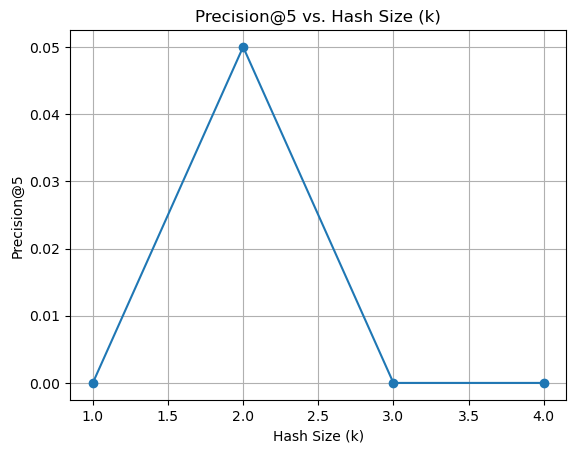

In [62]:
import matplotlib.pyplot as plt

# Function to calculate Precision@5
def precision_at_5(true_top_k_users, lsh_top_k_users):
    precision_sum = 0
    num_queries = len(true_top_k_users)
    
    for query_id in true_top_k_users.keys():
        true_top_users = set([user for user, _ in true_top_k_users[query_id]])
        lsh_top_users = set([user for user, _ in lsh_top_k_users[query_id]])
        
        # Precision is the ratio of intersection size to the size of the LSH set (which is 5)
        intersection_size = len(true_top_users.intersection(lsh_top_users))
        precision_sum += intersection_size / 5  # Precision@5 is based on top-5 users
    
    # Average precision over all queries
    return precision_sum / num_queries



# Function to run LSH for a given hash size k and compute Precision@5
def run_lsh_and_compute_precision(query_set, data, true_top_k_users, k, L=10, p=7919, bucket_size=3000):
    # Step 1: Construct LSH tables with hash size k
    lsh_tables = construct_multiple_lsh_tables(data, L, k=k, p=p, bucket_size=bucket_size)
    
    # Step 2: Get top-5 most similar users from LSH method (similar to 2(a))
    lsh_top_k_users = get_top_k_similar_users(compute_jaccard_similarities(get_collided_users_for_queries(query_set, lsh_tables, data), data), k=5)
    
    # Step 3: Compute Precision@5
    precision = precision_at_5(true_top_k_users, lsh_top_k_users)
    
    return precision

true_top_5_similar_users = compute_true_top_k_similar_users(query_set, data, k=5)

#Investigate the impact of k on Precision@5
k_values = [1, 2, 3, 4]
precision_values = []

for k in k_values:
    precision = run_lsh_and_compute_precision(query_set, data, true_top_5_similar_users, k=k, L=10, bucket_size=3000)
    precision_values.append(precision)
    print(f"Precision@5 for k={k}: {precision:.4f}")

# Step 4: Plot the curve
plt.plot(k_values, precision_values, marker='o')
plt.title("Precision@5 vs. Hash Size (k)")
plt.xlabel("Hash Size (k)")
plt.ylabel("Precision@5")
plt.grid(True)
plt.show()

### b) onsider the same query set Q in Question 3(a) and hash size k = 2. Compare the query time in Question 2(a) and Question 2(b) on average across the query set Q in milliseconds and comment ontheir differences (if any).

In [64]:
import time

# Function to measure query time for a given function
def measure_query_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    elapsed_time = (end_time - start_time) * 1000  # Convert to milliseconds
    return elapsed_time

# Step 1: Measure query time for LSH-based nearest neighbor search
def measure_lsh_query_time(query_set, data, k=2, L=10, p=7919, bucket_size=3000):
    # Construct LSH tables (as done in previous tasks)
    lsh_tables = construct_multiple_lsh_tables(data, L, k=k, p=p, bucket_size=bucket_size)
    
    # Measure query time for each user in the query set using LSH
    total_time = 0
    for query_id in query_set:
        query_vector = data[data['User_ID'] == query_id]['Visited_Businesses'].values[0]
        elapsed_time = measure_query_time(find_collided_users, query_vector, lsh_tables, p, len(query_vector), bucket_size)
        total_time += elapsed_time
    
    # Compute average query time
    avg_query_time_lsh = total_time / len(query_set)
    return avg_query_time_lsh

# Step 2: Measure query time for exhaustive search
def measure_exhaustive_query_time(query_set, data):
    total_time = 0
    for query_id in query_set:
        query_vector = data[data['User_ID'] == query_id]['Visited_Businesses'].values[0]
        
        # Measure the time taken to compute similarities with all users in the dataset
        elapsed_time = measure_query_time(compute_true_top_k_similar_users, [query_id], data, k=5)
        total_time += elapsed_time
    
    # Compute average query time
    avg_query_time_exhaustive = total_time / len(query_set)
    return avg_query_time_exhaustive

# Step 3: Define the query set Q
query_set = [295, 1053, 1080, 2186]

# Step 4: Measure average query time for LSH-based method
avg_query_time_lsh = measure_lsh_query_time(query_set, data, k=2, L=10, bucket_size=3000)
print(f"Average query time for LSH-based search: {avg_query_time_lsh:.2f} ms")

# Step 5: Measure average query time for exhaustive search
avg_query_time_exhaustive = measure_exhaustive_query_time(query_set, data)
print(f"Average query time for exhaustive search: {avg_query_time_exhaustive:.2f} ms")

# Step 6: Comment on the differences
if avg_query_time_lsh < avg_query_time_exhaustive:
    print("LSH-based search is faster than exhaustive search.")
else:
    print("Exhaustive search is faster than LSH-based search.")


Average query time for LSH-based search: 14.45 ms


TypeError: measure_query_time() got an unexpected keyword argument 'k'